In [2]:
import torch
import config
import numpy as np
import matplotlib.pyplot as plt
import os
from Alg.solving_algorithm import ModelGenerator
from CustomModels.my_models import Integrator
from CustomModels.my_models import weighted_amount,renormolize_distribution
from aml.plotting import *
from Losses.Losses import *
from sklearn import decomposition
from tqdm import tqdm
from scipy.spatial import ConvexHull
from scipy.optimize import minimize

def adjust_alpha(alpha_n):
    for j in range(len(alpha_n)):
        if alpha_n[j]<0.0:
            alpha_n[j] = 0.0
        elif alpha_n[j] > 1.0:
            alpha_n[j] = 1.0
    alpha_n = alpha_n/np.sum(alpha_n)
    return alpha_n 

def Temp(k,T_0,max_iter):
    # return T_0/np.log(k+2)
    # return T_0/k
    a = -T_0/max_iter
    b = T_0
    return a*k+b

def ProbOfChangeToNewParams(L_new, L_old, beta, current_temp):
    H_ = 0.0
    if L_new < L_old:
        H_ = 1.0
    else:
        H_=  np.minimum(1.0,np.exp((L_old-L_new)/(beta*current_temp)))
        # H_ = 0.0
    return H_

def UpdateMu(mu_current,mu_new,epsilon,ProbOfUpdate):
    if ProbOfUpdate == 1.0:
        # new_ = epsilon*mu_current + (1-epsilon)*mu_new
        new_ = mu_new
        new_ = new_/np.sum(new_)
        return  new_, True
    if ProbOfUpdate == 0.0:
        return  mu_current, False
    
    v_ = ProbOfUpdate*1000
    coin_=  np.random.randint(0,1001)
    if coin_ <= v_:
        new_ = mu_new
        # new_ = epsilon*mu_current + (1-epsilon)*mu_new
        new_ = new_/np.sum(new_)
        return new_, True
    else:
        return mu_current,False
        
def GenAlphaVec(mu_current, value_of_noise):
    noise = np.random.rand(len(mu_current))
    noise = noise/np.sum(noise)
    new_ = (1.0-value_of_noise)*mu_current + value_of_noise* noise
    new_ = new_/np.sum(new_)
    return new_

def adjust_alpha(alpha_n):
    for j in range(len(alpha_n)):
        if alpha_n[j]<0.0:
            alpha_n[j] = 0.001
        elif alpha_n[j] > 1.0:
            alpha_n[j] = 1.0
    alpha_n = alpha_n/np.sum(alpha_n)
    return alpha_n 

def grad_descent_from_alpha(Lstorage,MutationMask,
                            alpha_vec,p_0, shared_integration_supports,a,board,exp_meta,
                            MAX_ITER,MAX_GENERATIONS,T_0):
    d= len(alpha_vec)   
    alpha_n = np.copy(alpha_vec)
    alpha_n = alpha_n/np.sum(alpha_n)
    p_n = renormolize_distribution(p_0,a,alpha_n)
    L_n = get_L2_Distrib4D(p_n, shared_integration_supports)
    best_alpha_n = None
    best_L = L_n
    L_0 = L_n
    # append first value of loss
    Lstorage.append(L_0)
    MutationMask.append(-1)
    
    print('start of alg')
    for ITER in range(MAX_ITER):
        # update info from prev step
        board.Push(experiment_metadata=exp_meta,
        x=ITER,y= L_n, label='L')
        # if ITER % 10 ==0:
            # print('ITER {} L_n {}'.format(ITER,L_n))
            # print(alpha_n)
        # else:


        # make step 
        p_n=  renormolize_distribution(p_n,a,alpha_n)
        L_n = get_L2_Distrib4D(p_n,shared_integration_supports)
        # Lstorage.append(L_n)


        
        gradient_ = np.zeros(shape=(d,))
        epsilon_ = 10**(-1)
        for j in range(d):
            if alpha_n[j] < epsilon_:
                alpha_1 = np.copy(alpha_n)
                alpha_1[j] = alpha_1[j] + epsilon_
                alpha_1 = alpha_1/np.sum(alpha_1)

                p_1 = renormolize_distribution(p_n,a,alpha_1)
                L_1 = get_L2_Distrib4D(p_1,shared_integration_supports)
                gradient_[j] = (L_1 - L_n)/epsilon_
                continue
            if alpha_n[j] > 1.0-epsilon_:
                alpha_2 = np.copy(alpha_n)
                alpha_2[j] = alpha_2[j] - epsilon_
                alpha_2 = alpha_2/np.sum(alpha_2)
                p_2 = renormolize_distribution(p_n,a,alpha_2)
                L_2 = get_L2_Distrib4D(p_2,shared_integration_supports)
                gradient_[j] = (L_n-L_2)/epsilon_
                continue
            
            alpha_1 = np.copy(alpha_n)
            alpha_1[j] = alpha_1[j] + epsilon_
            alpha_2 = np.copy(alpha_n)
            alpha_2[j] = alpha_2[j] - epsilon_
            
            alpha_1 = alpha_1/np.sum(alpha_1)
            alpha_2 = alpha_2/np.sum(alpha_2)


            p_1 = renormolize_distribution(p_n,a,alpha_1)
            p_2 = renormolize_distribution(p_n,a,alpha_2)

            L_1 = get_L2_Distrib4D(p_1,shared_integration_supports)
            L_2 = get_L2_Distrib4D(p_2,shared_integration_supports)
            gradient_[j] = (L_1 - L_2)/(2*epsilon_)

        board.Push(experiment_metadata=exp_meta,
        x=ITER,y= np.linalg.norm(gradient_), label='grad norm')
        lambda_vec = np.logspace(start=4,stop=-4,num=10)
        lambda_best = None
        loss_current = L_n
        ls = []
        lambda_ls = []
        for lambda_ in lambda_vec:
            alpha_copy = np.copy(alpha_n)
            alpha_after = alpha_copy - lambda_*gradient_
            if np.sum(alpha_after < 0.0)==d:
                continue
            alpha_after = adjust_alpha(alpha_after)        
            p_after = renormolize_distribution(p_n,a,alpha_after)
            L_after = get_L2_Distrib4D(p_after,shared_integration_supports)
            ls.append(L_after)
            lambda_ls.append(lambda_)
            if L_after<loss_current:
                loss_current = L_after
                lambda_best = lambda_
        arg_best = np.argsort(ls)[0]
        left_pos = np.maximum(0, arg_best-1)
        right_pos = np.minimum(len(ls)-1, arg_best+1)

        left = lambda_ls[left_pos]
        right = lambda_ls[right_pos]

        lambda_vec = np.linspace(left,right,10)
        addls = []
        addlambda_ls = []
        for lambda_ in lambda_vec:
            alpha_copy = np.copy(alpha_n)
            alpha_after = alpha_copy - lambda_*gradient_
            if np.sum(alpha_after < 0.0)==d:
                continue
            alpha_after = adjust_alpha(alpha_after)        
            p_after = renormolize_distribution(p_n,a,alpha_after)
            L_after = get_L2_Distrib4D(p_after,shared_integration_supports)
            addls.append(L_after)
            addlambda_ls.append(lambda_)
            if L_after<loss_current:
                loss_current = L_after
                lambda_best = lambda_
                
        if lambda_best == None:
            alpha_n = alpha_n + epsilon_*np.random.rand(d)
            alpha_n = alpha_n/np.sum(alpha_n)
            MutationMask.append(1)
        else:
            fig,ax = plt.subplots()
            ax.plot(lambda_ls, ls)
            ax.set_xscale('log')
            plt.show()
            MutationMask.append(0)
            alpha_n = alpha_n - lambda_best*gradient_
            alpha_n = adjust_alpha(alpha_n)
            # print(alpha_n)
            # torch.save(alpha_n, os.path.join(config.task_dir,'alpha_rules_descent.txt'))

        p_n =  renormolize_distribution(p_n,a,alpha_n)
        L_n = get_L2_Distrib4D(p_n,shared_integration_supports)
        Lstorage.append(L_n)
        print('ITER {} L_n {}'.format(ITER,L_n))
        if L_n < best_L:
            best_alpha_n = alpha_n
            best_L = L_n

    if best_alpha_n is not None:
        p_final = renormolize_distribution(p_0,a,best_alpha_n)
        L_final = best_L
        alpha_final  = best_alpha_n
        return p_final, L_final, alpha_final
    else:
        print('меньшее значение не найдено')
        return None

def make_obj_func(p_0, a, shared_integration_supports):
    def get_l_by_alpha(alpha_vec):
        p_ = renormolize_distribution(p_0,a,alpha_vec)
        L_ = get_L2_Distrib4D(p_, shared_integration_supports)
        return L_
    return get_l_by_alpha

def grad_descent_from_alpha_auto(alpha_vec,p_0, shared_integration_supports,a,board,exp_meta,
                            MAX_ITER,MAX_GENERATIONS,T_0):
    d = len(alpha_vec)
    print('dimension of problem {}'.format(d))
    alpha_0 = np.copy(alpha_vec)
    obj_func = make_obj_func(p_0,a,shared_integration_supports)
    start_Loss = obj_func(alpha_0)
    print('start from {}'.format(start_Loss))
    bounds = np.zeros(shape=(d,2))
    for j in range(d):
        bounds[j][0] = 0.0
        bounds[j][1] = 1.0
    cons = [{"type": "eq", "fun": lambda x: np.sum(x)-1.0}]
    options = {
        'verbose':2
    }

    results = minimize(fun=obj_func, x0=alpha_0,method='trust-constr', bounds=bounds,constraints=cons,options=options)
    best_alpha = results['x']
    print(results)
    print(best_alpha)
    fig0,ax0= plt.subplots()
    fig0.set_size_inches(16,9)
    ax0.bar(x= np.arange(0,d),height=best_alpha)
    ax0.set_title(r'$P_{\gamma}(k)$')
    # ax0.set_xlim(-1,50)
    ax0.set_xlabel(r'$k$')
    plt.show()
    raise SystemExit


In [3]:


# alpha_best_ = None
# T_n = T_0
# p_n = p_0
# L_best = 10**99
# L_current = 10**99
# # all_losses = []
# # while True:
# #     p_n=  renormolize_distribution(p_n,a,alpha_n)
# #     L_n = get_L2_Distrib4D(p_n,shared_integration_supports)
    
# #     n +=1    
# l_all = []
# for ITER in tqdm(range(MAX_ITER)):
#     sigma_n = T_n/T_0
#     for j in range(MAX_GENERATIONS):
#         alpha_ = GenAlphaVec(mu_current=alpha_n, value_of_noise=0.3*sigma_n)
#         p_ = renormolize_distribution(p_n, a, alpha_)
#         L_new = get_L2_Distrib4D(p_,shared_integration_supports)
#         H_ = ProbOfChangeToNewParams(L_new,L_current, 1.0,T_n)
#         board.Push(experiment_metadata=exp_meta,
#             x=ITER,y= H_, label='H')
#         alpha_updated, is_update = UpdateMu(alpha_n,alpha_,epsilon=0.8,ProbOfUpdate=H_)
#         if is_update:
#             board.Push(experiment_metadata=exp_meta,
#             x=ITER,y= L_new, label='L')

#         if is_update and (L_new<L_current):
#             L_current = L_new
#             alpha_n = alpha_updated
#             break
#         elif is_update and not (L_new<L_current):
#             L_current = L_new
#             alpha_n = alpha_updated

#         if L_new < L_best:
#             L_best = L_new
#             alpha_best_ = np.copy(alpha_updated)
#     if ITER % 10 ==0:
#         print(alpha_n)
#     T_n = Temp(ITER,T_0,MAX_ITER)
#     board.Push(experiment_metadata=exp_meta,
#             x=ITER,y= T_n, label='T')
# p_n = renormolize_distribution(p_n,a,alpha_n)
# return p_n, L_current,alpha_n

def approx_equal(x1,x2,precision):
    if np.absolute(x1-x2) < precision:
        return True
    else:
        return False

In [4]:
board = TensorBoard(tensorboard_exe_path=config.tensorboard_path,
                    logdir=os.path.join(config.task_dir, 'rules_descent_log'),
                    port= '64001',
                    mode='linux')

tensorboard http://localhost:64001/


2024-04-24 20:48:30.719281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 20:48:30.719313: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 20:48:30.719335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 20:48:30.724197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 20:48:31.296758: W tensorflow/compiler/

In [5]:
mg = ModelGenerator(rules=config.rules,
                            cache_dir=config.Phi_cache_dir,
                            clear_cache=False)
shared_integration_supports = Integrator(dir_=config.integrator_dir,
                                        shared_data=mg.shared_data,
                                        clear_cache=True).shared_integration_supports
N=1000
all_p = [torch.load(os.path.join(mg.cache_dir, 'distrib4D_{}.txt'.format(i))) for i in range(N)]
all_v=  torch.load(os.path.join(config.task_dir, 'L2_for_Phi.txt'))
nr = len(all_p[0].z_list)
uniform_distrib_of_rules= np.ones(shape=(nr,))/nr
a, h, f, coeff_list = mg.shared_data['ahfcoeff_list']
a = [a[el].detach().numpy() for el in range(len(a))]
for i in range(N):
    all_p[i] = renormolize_distribution(all_p[i],a,uniform_distrib_of_rules)

     num_of_rect_in_intersection 17090


choose start distribtuion by random choise

In [8]:
# p_0 = all_p[np.argmin(all_v)]
# p_0_pos = np.random.randint(0,N)
# print(p_0_pos)
# p_0 = all_p[p_0_pos]
# p_0_pos = np.random.randint(0,N)
# print(p_0_pos)
p_0_pos = 948
p_0 = all_p[p_0_pos]
print(p_0_pos)

948


make gradiend descent on distribution in $R^{n_{r}}$

In [9]:
exp_metadata = 'спуск_по_правилам_final'+get_time()
board.InitExperiment(experiment_metadata= exp_metadata)

2024-04-24 20:49:25.273177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 20:49:25.274293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 20:49:25.274493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
alpha_n = np.copy(uniform_distrib_of_rules)
T_0 = 0.002
MAX_GENERATIONS = 1000
MAX_ITER = 30

start of alg


2024-04-24 20:49:34.445159: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:521] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.8
  /usr/local/cuda
  /home/user/work/penv/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/user/work/penv/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
2024-04-24 20:49:34.460304: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 20:49:34.463421: I tensorflow/tsl/platform

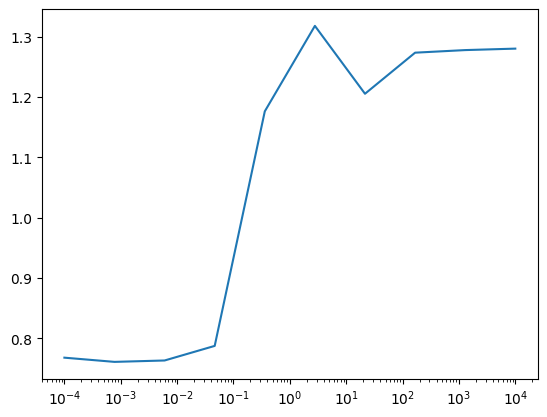

ITER 0 L_n 0.7575085883562904
ITER 1 L_n 0.799694813150795


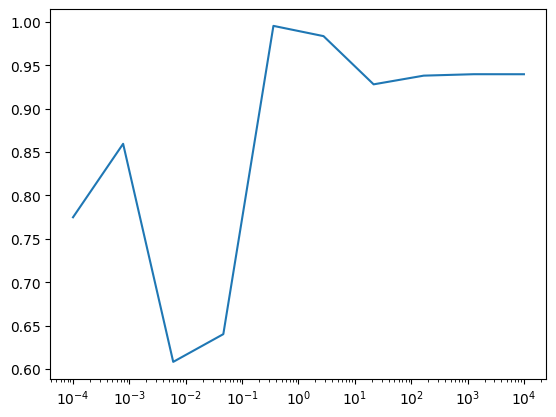

ITER 2 L_n 0.6038320064278969


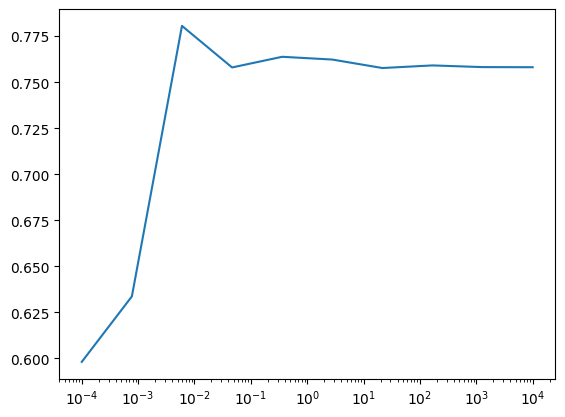

ITER 3 L_n 0.5981020517130193
ITER 4 L_n 0.7796785430748607


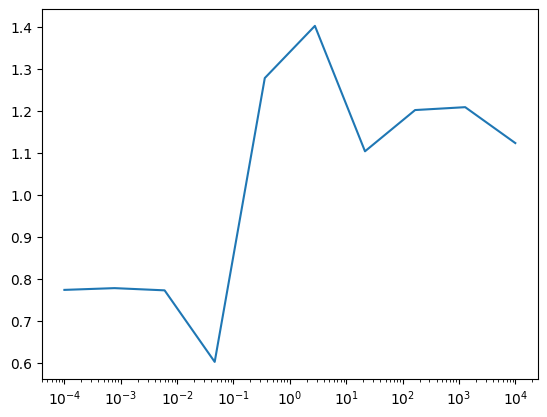

ITER 5 L_n 0.589720984203962
ITER 6 L_n 0.7713585901504543


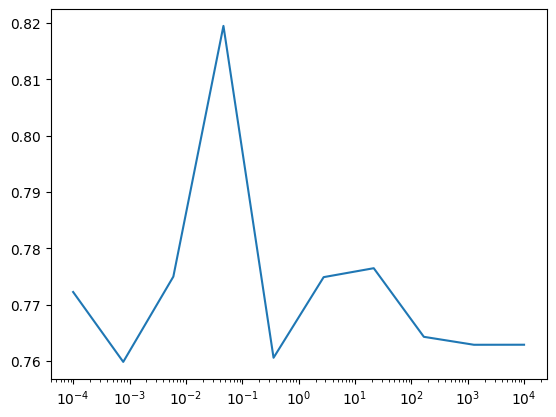

ITER 7 L_n 0.7487171157615006


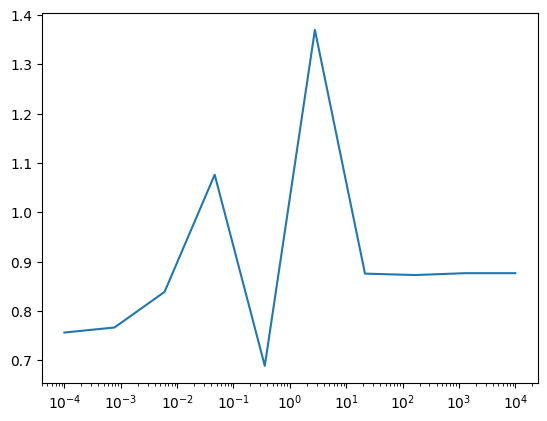

ITER 8 L_n 0.6821202236407136


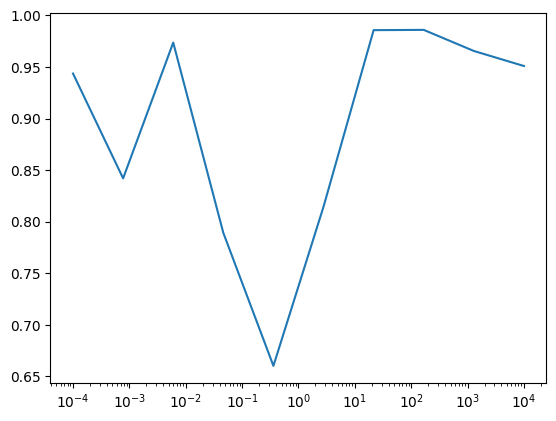

ITER 9 L_n 0.6207080160053493


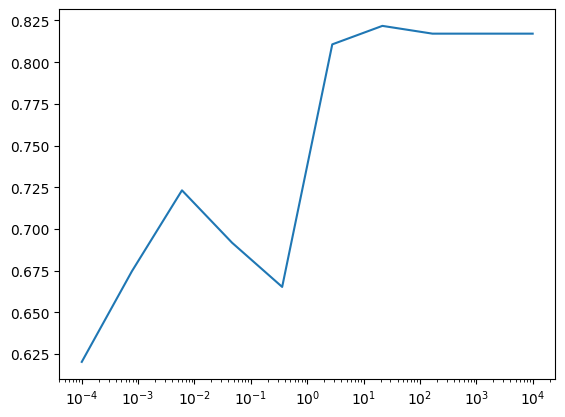

ITER 10 L_n 0.6203248202781889
ITER 11 L_n 0.7751199914935667


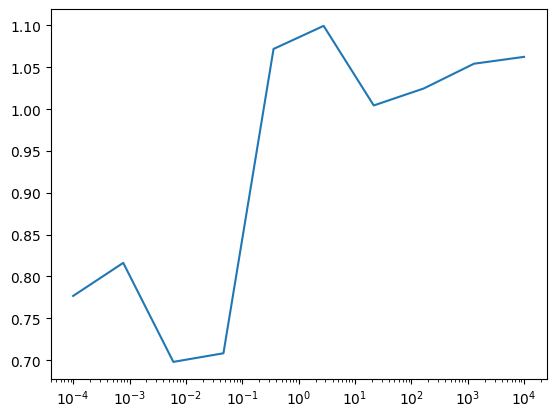

ITER 12 L_n 0.5349419131300016
ITER 13 L_n 0.7608568790065775


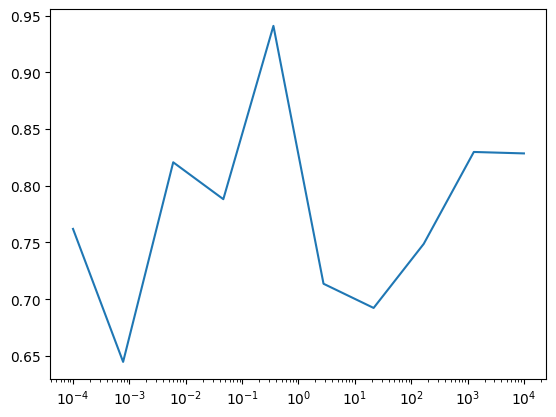

ITER 14 L_n 0.6389428016957638


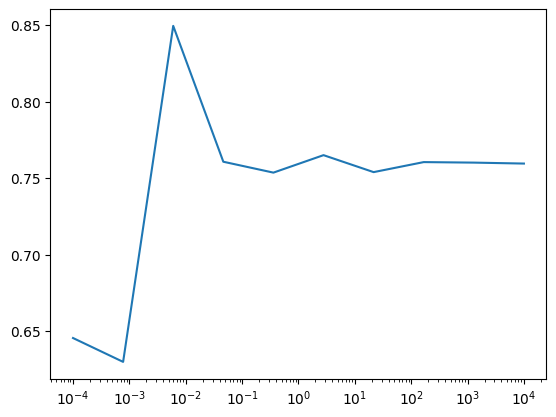

ITER 15 L_n 0.629800401081759


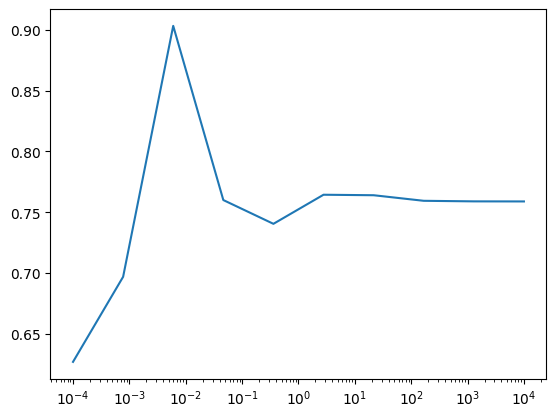

ITER 16 L_n 0.6105503116326543
ITER 17 L_n 0.7832998958242249


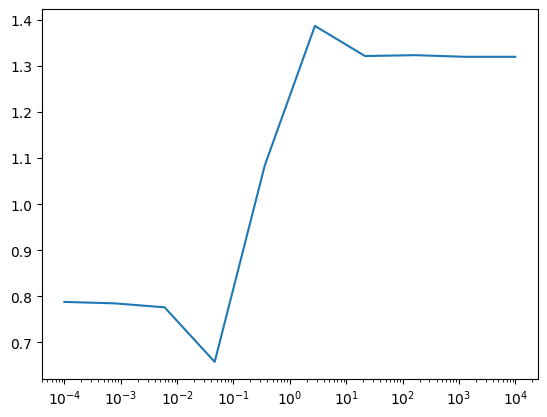

ITER 18 L_n 0.6502593916980409


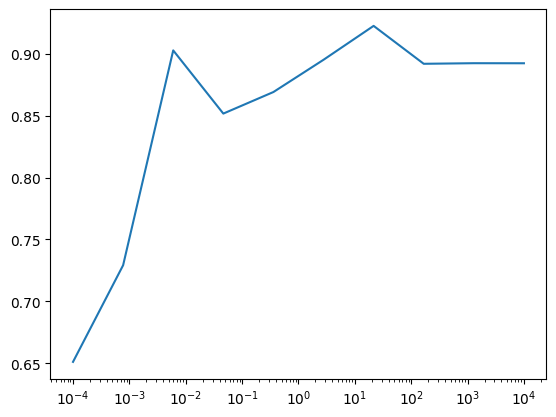

ITER 19 L_n 0.6463276337797547
ITER 20 L_n 0.7726837445304805


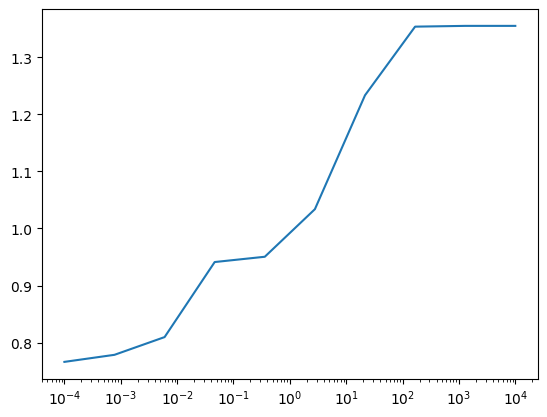

ITER 21 L_n 0.7661704818411529


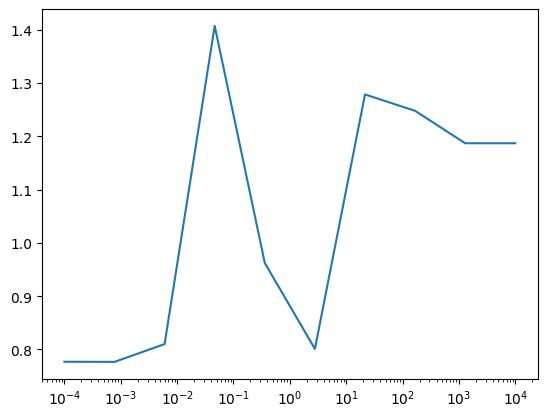

ITER 22 L_n 0.7643091966918801


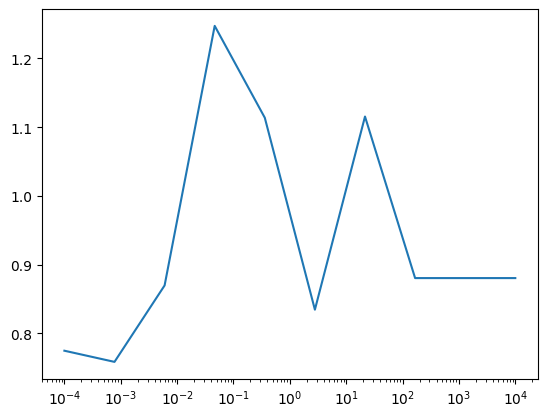

ITER 23 L_n 0.7586159904456905


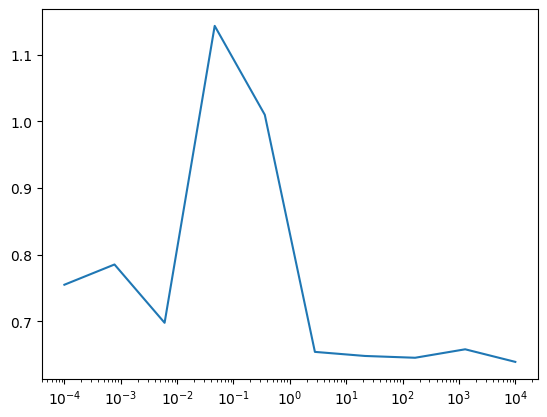

ITER 24 L_n 0.6381067747624938
ITER 25 L_n 0.889674942217612


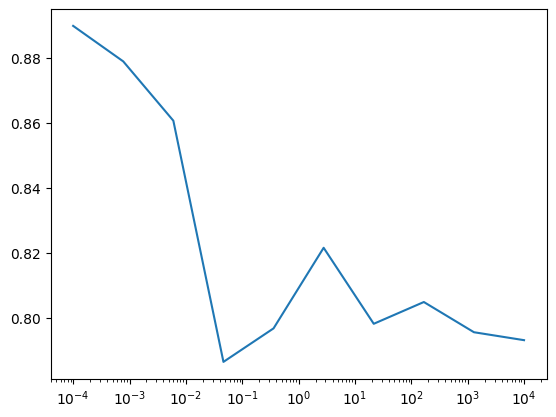

ITER 26 L_n 0.7829639965240806


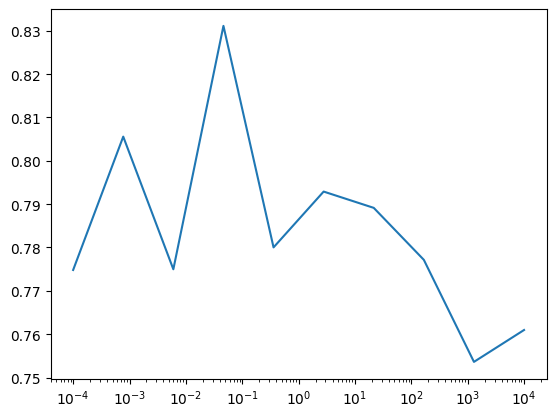

ITER 27 L_n 0.7536068361941113
ITER 28 L_n 0.7665701220660149


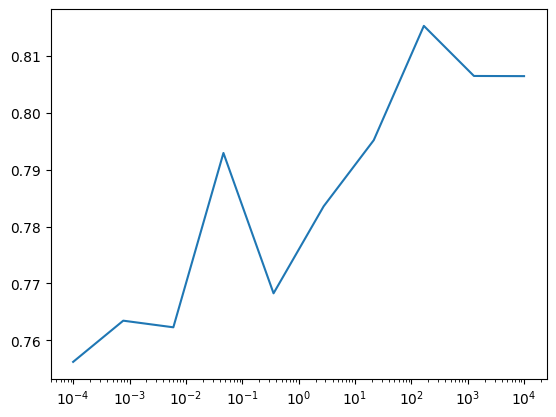

ITER 29 L_n 0.7514180831277337


In [11]:
Lstorage = []
MutationMask = []
p_final, L_final, alpha_final = grad_descent_from_alpha(
                                                    Lstorage,
                                                    MutationMask,
                                                    alpha_n,
                                                    p_0,
                                                        shared_integration_supports,
                                                        a,
                                                        board,
                                                        exp_metadata,
                                                        MAX_ITER,
                                                        MAX_GENERATIONS,
                                                        T_0)

In [12]:
def set_font_size_to(ax,font_size=None):
    if font_size is not None:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(font_size)

def save_plot_to(fig, path):
    fig.savefig(path, bbox_inches = 'tight')

In [13]:
path_to_save = config.plots_path

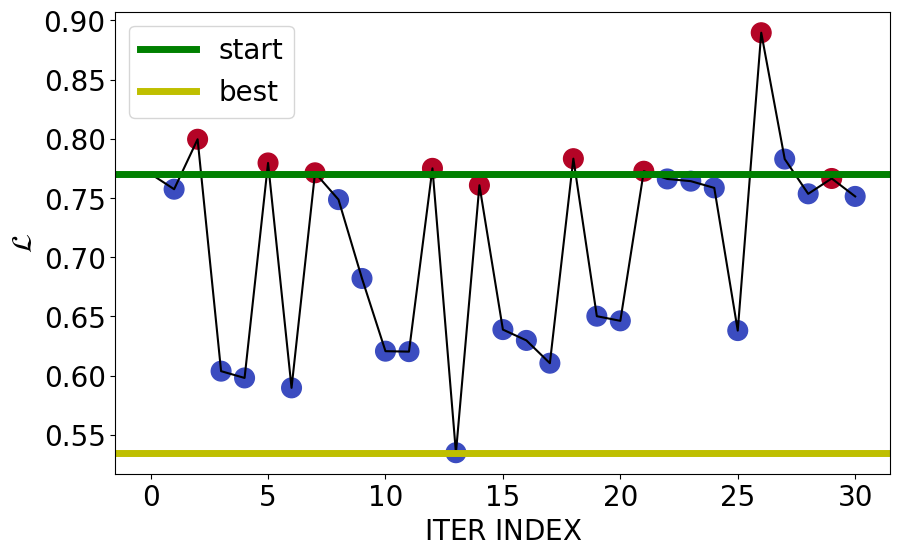

In [14]:
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
ax.plot(np.arange(len(Lstorage)),Lstorage,c='k')
MutationMaskCopy = MutationMask.copy()
ax.scatter(np.arange(len(Lstorage)-1)+1, Lstorage[1:], marker='o',c = MutationMaskCopy[1:],cmap='coolwarm',s = 200)

ax.axhline(Lstorage[0],c='g',label='start',linewidth = 5)
ax.axhline(min(Lstorage),c='y',label='best',linewidth = 5)
ax.set_ylabel(r'$\mathcal{L}$')
ax.set_xlabel(r'$\text{ITER INDEX}$')
set_font_size_to(ax,20)
ax.legend(prop={'size': 20})
save_plot_to(fig, os.path.join(path_to_save, 'rule_descent_loss.png'))

In [15]:
def plot_distr_of_rules(distr):
    fig,ax = plt.subplots()
    fig.set_size_inches(4,3)
    ax.bar(np.arange(start=0,stop=len(distr)), distr, color ='k', 
        width = 0.4)
    return fig,ax

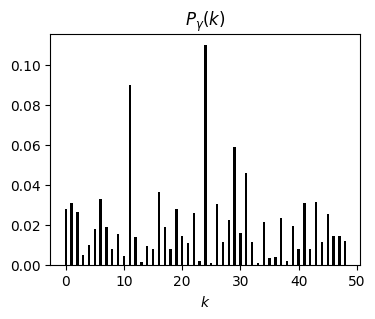

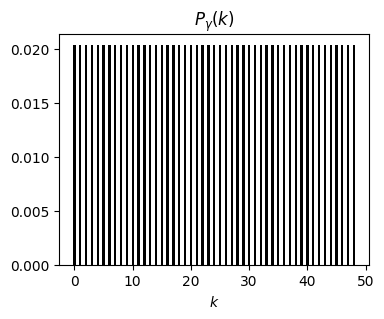

In [17]:
fig,ax = plot_distr_of_rules(alpha_final)
ax.set_title(r'$P_{\gamma}(k)$')
ax.set_xlabel(r'$k$')
save_plot_to(fig,os.path.join(path_to_save,'drules_after_opt.png'))
fig,ax = plot_distr_of_rules(alpha_n)
ax.set_title(r'$P_{\gamma}(k)$')
ax.set_xlabel(r'$k$')
save_plot_to(fig, os.path.join(path_to_save,'drules_before_opt.png'))


start plot response surface

num_of_points_in_plot 961
min F -0.9399497500546178, max F 0.931510732330676
 interation 960 of 961plot response surface done
точка по theta 1/10
точка по theta 2/10
точка по theta 3/10
точка по theta 4/10
точка по theta 5/10
точка по theta 6/10
точка по theta 7/10
точка по theta 8/10
точка по theta 9/10
точка по theta 10/10
0.11087179183959961


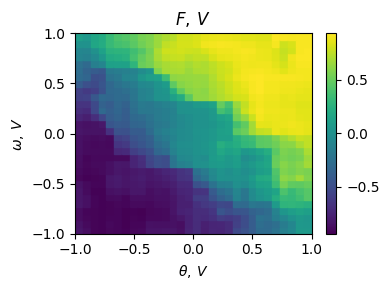

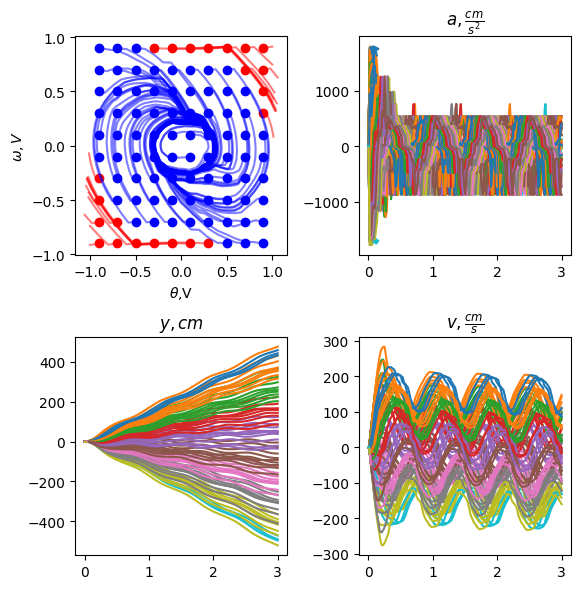

In [18]:
p_func = Integrator.make_policy_function(p_xi_eta_gamma=p_final,
                                            new_omega_list=shared_integration_supports['new_omega_list'],
                                            list_for_integrate=shared_integration_supports['list_for_integrate'],
                                            projection_to_x_y_info=shared_integration_supports[
                                                'projection_to_x_y_info'],
                                            shared_Rects=shared_integration_supports['Rects'],
                                            shared_Grids=shared_integration_supports['Grids'],
                                            print_time_of_this_func=False
                                            )
fig1,axs1 = plot_policy_function(mode_of_plot='map',
                        filepath_to_save_response_surface='',
                        p_func=p_func,
                        Grids=shared_integration_supports['Grids'],
                        block_canvas=False
                        )
fig1.set_size_inches(4,3)
condition_of_break = np.asarray([
    config.theta_range,
    config.omega_range,
    [-9999.0, 9999.0],
    [-9999.0, 9999.0]
])
psi = make_psi(policy_func=p_func,
                translators_units_of_measurement=config.translators_units_of_measurement)

sym_params_ =  {'x_1_range': [-0.9, 0.9], 'x_2_range': [-0.9,  0.9],  'n_x_for_sim': 10, 'n_y_for_sim': 10}
simulation = make_simulation_for_one_policy_function(
    psi=psi,
    phys_sim_params=config.phys_sim_params,
    condition_of_break=condition_of_break,
    object_params=config.phys_params,
    use_an_early_stop=False
)

T = config.phys_sim_params['t_end']


results_ = get_sim_results(simulation=simulation,
                        phys_sim_params=config.phys_sim_params,
                        plot_tr_params=sym_params_,
                        units_translators=config.translators_units_of_measurement)
fig2,ax2 = plot_trajectories(simulation=simulation,
                    phys_sim_params=config.phys_sim_params,
                    plot_tr_params=sym_params_,
                    units_translators=config.translators_units_of_measurement,
                    make_animation=False)
fig2.set_size_inches(6,6)
fig2.tight_layout()
save_plot_to(fig1,os.path.join(path_to_save, 'rd_policy_after.png'))
save_plot_to(fig2,os.path.join(path_to_save, 'rd_summary_after.png'))



start plot response surface

num_of_points_in_plot 961
min F -0.9347551117480302, max F 0.9245266340182431
 interation 960 of 961plot response surface done
точка по theta 1/10
точка по theta 2/10
точка по theta 3/10
точка по theta 4/10
точка по theta 5/10
точка по theta 6/10
точка по theta 7/10
точка по theta 8/10
точка по theta 9/10
точка по theta 10/10
0.11510848999023438


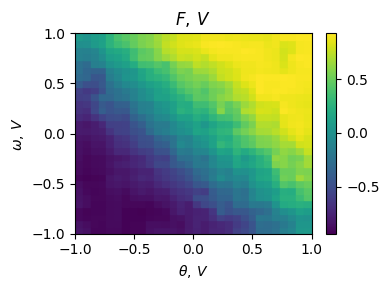

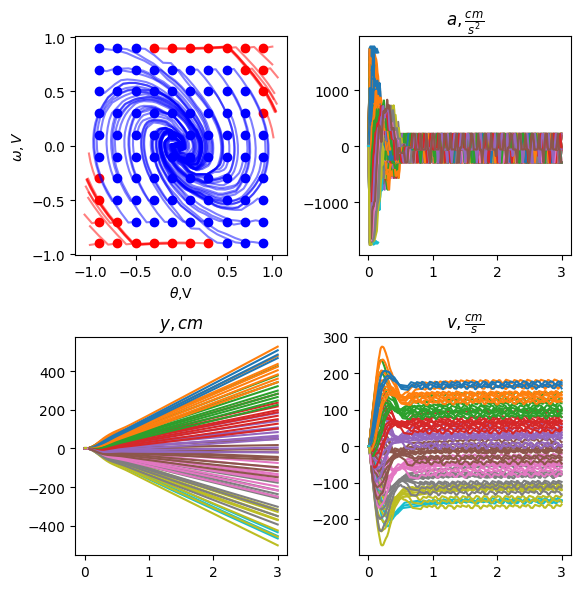

In [19]:
p_func = Integrator.make_policy_function(p_xi_eta_gamma=renormolize_distribution(p_0,a,alpha_n),
                                            new_omega_list=shared_integration_supports['new_omega_list'],
                                            list_for_integrate=shared_integration_supports['list_for_integrate'],
                                            projection_to_x_y_info=shared_integration_supports[
                                                'projection_to_x_y_info'],
                                            shared_Rects=shared_integration_supports['Rects'],
                                            shared_Grids=shared_integration_supports['Grids'],
                                            print_time_of_this_func=False
                                            )
fig1,axs1 = plot_policy_function(mode_of_plot='map',
                        filepath_to_save_response_surface='',
                        p_func=p_func,
                        Grids=shared_integration_supports['Grids'],
                        block_canvas=False
                        )
fig1.set_size_inches(4,3)
condition_of_break = np.asarray([
    config.theta_range,
    config.omega_range,
    [-9999.0, 9999.0],
    [-9999.0, 9999.0]
])
psi = make_psi(policy_func=p_func,
                translators_units_of_measurement=config.translators_units_of_measurement)

sym_params_ =  {'x_1_range': [-0.9, 0.9], 'x_2_range': [-0.9,  0.9],  'n_x_for_sim': 10, 'n_y_for_sim': 10}
simulation = make_simulation_for_one_policy_function(
    psi=psi,
    phys_sim_params=config.phys_sim_params,
    condition_of_break=condition_of_break,
    object_params=config.phys_params,
    use_an_early_stop=False
)

T = config.phys_sim_params['t_end']


results_ = get_sim_results(simulation=simulation,
                        phys_sim_params=config.phys_sim_params,
                        plot_tr_params=sym_params_,
                        units_translators=config.translators_units_of_measurement)
fig2,ax2 = plot_trajectories(simulation=simulation,
                    phys_sim_params=config.phys_sim_params,
                    plot_tr_params=sym_params_,
                    units_translators=config.translators_units_of_measurement,
                    make_animation=False)
fig2.set_size_inches(6,6)
fig2.tight_layout()
save_plot_to(fig1,os.path.join(path_to_save, 'rd_policy_before.png'))
save_plot_to(fig2,os.path.join(path_to_save, 'rd_summary_before.png'))